In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import *
from ml.tfidf import TFIDFModel
%matplotlib inline

/Users/jeremy/Development/anaconda/envs/ml/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Clean up the data to remove duplicates, nulls and noise (wikipedia redirects)

In [2]:
#If new records have been added, run this routine to clean up and remove dups
#fauna = pd.read_csv('./ml/datasets/fauna.csv.gz', compression='gzip')
#print('fauna.shape before nulls removed', fauna.shape)
#fauna = fauna[fauna['class'].notnull()]
#fauna = fauna[fauna['text'].notnull()]
#fauna = fauna[fauna['order'].notnull()]
#print('fauna.shape after nulls removed', fauna.shape)
#print('fauna.shape before duplicates removed', fauna.shape)
#fauna = fauna.drop_duplicates(['page-id'], keep='first')
#print('fauna.shape after duplicates removed', fauna.shape)
#fauna = fauna.drop(fauna[fauna['text'].str.contains('This is a redirect')].index)
#print('fauna.shape after redirects dropped', fauna.shape)
#print(fauna.shape)
#fauna.to_csv('./ml/datasets/fauna-{}.csv.gz'.format(fauna.shape[0]), compression='gzip', index=False)

### Load the fauna data

In [3]:
fauna = pd.read_csv('./ml/datasets/fauna-53699.csv.gz', compression='gzip')

In [4]:
print(fauna.shape)
fauna.head()

(53699, 10)


,class,family,genus,kingdom,order,page-id,phylum,species,text,title
0,mammalia,muridae,acomysigeoffroy1838,animalia,rodentia,2375794,chordata,NaN,The term spiny mouse refers to any species of ...,Spiny mouse
1,mammalia,muridae,lophuromys,animalia,rodentia,12173296,chordata,lmelanonyx,The black-clawed brush-furred rat (Lophuromys ...,Black-clawed brush-furred rat
2,mammalia,erinaceidae,NaN,animalia,eulipotyphla,46590,chordata,NaN,A hedgehog is any of the spiny mammals of the ...,Hedgehog
3,mammalia,erinaceidae,hylomys,animalia,eulipotyphla,3422827,chordata,hparvus,The dwarf gymnure (Hylomys parvus) is a gymnur...,Dwarf gymnure
4,mammalia,muridae,acomys,animalia,rodentia,12171686,chordata,amullah,The Mullah spiny mouse (Acomys mullah) is a sp...,Mullah spiny mouse


### Visualize the number of records in each class

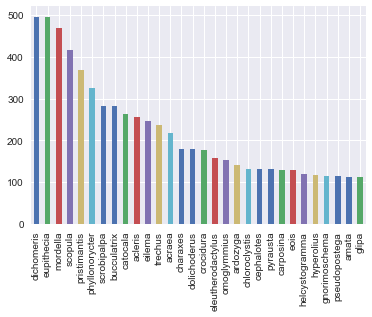

In [5]:
classes = fauna['genus'].value_counts()
classes[0:30].plot(kind="bar")


### Basic filtering on various fields

In [6]:
fauna[fauna['title']=='Red panda']

,class,family,genus,kingdom,order,page-id,phylum,species,text,title
1317,mammalia,ailuridae,ailurusfcuvier1825,animalia,carnivora,26441,chordata,afulgens,"The red panda (Ailurus fulgens), also called t...",Red panda


### Comparing similar and disimilar species

In [7]:
bears = fauna[fauna['family'] == 'ursidae']
bears.head()

,class,family,genus,kingdom,order,page-id,phylum,species,text,title
187,mammalia,ursidae,ailuropodamilneedwards1870,animalia,carnivora,339548,chordata,NaN,Ailuropoda is the only extant genus in the urs...,Ailuropoda
190,mammalia,ursidae,NaN,animalia,carnivora,5478888,chordata,NaN,Ailuropodinae is a subfamily of Ursidae that c...,Ailuropodinae
250,mammalia,ursidae,kretzoiarctosabellaetal2012,animalia,carnivora,46316720,chordata,kretzoiarctosbeatrixabellaetal2011,Kretzoiarctos beatrix is an extinct bear from ...,Kretzoiarctos beatrix
407,mammalia,ursidae,melursusmeyer1793,animalia,carnivora,399740,chordata,mursinus,"The sloth bear (Melursus ursinus), also known ...",Sloth bear
1332,mammalia,ursidae,ursus,animalia,carnivora,51054,chordata,uamericanus,The American black bear (Ursus americanus) is ...,American black bear


In [8]:
sharks = fauna[fauna['family'] == 'lamnidae']
sharks.head()

,class,family,genus,kingdom,order,page-id,phylum,species,text,title
134,chondrichthyes,lamnidae,carcharodonasmith1838,animalia,lamniformes,43619,chordata,ccarcharias,The great white shark (Carcharodon carcharias)...,Great white shark
2144,chondrichthyes,lamnidae,isurus,animalia,lamniformes,766132,chordata,ioxyrinchus,"The shortfin mako shark (Isurus oxyrinchus), a...",Shortfin mako shark
3881,chondrichthyes,lamnidae,lamnacuvier1816,animalia,lamniformes,8874336,chordata,NaN,Lamna is a genus of mackerel sharks in the fam...,Lamna
4420,chondrichthyes,lamnidae,isurus,animalia,lamniformes,5640856,chordata,ipaucus,The longfin mako shark (Isurus paucus) is a sp...,Longfin mako shark
5269,chondrichthyes,lamnidae,isurus,animalia,lamniformes,47090510,chordata,iplanus,"Isurus planus, also known as the hook-tooth ma...",Isurus planus


In [9]:
beetles = fauna[fauna['order'] == 'coleoptera']
beetles.head()

,class,family,genus,kingdom,order,page-id,phylum,species,text,title
799,insecta,tenebrionidae,eleodeseschscholtz1829,animalia,coleoptera,17247312,arthropoda,NaN,"Pinacate beetles, also known as stink beetles,...",Pinacate beetle
1139,insecta,NaN,NaN,animalia,coleoptera,339399,arthropoda,NaN,A weevil is a type of beetle from the Curculio...,Weevil
1572,insecta,carabidaelatreille1802,NaN,animalia,coleoptera,417048,arthropoda,NaN,"Ground beetles are a large, cosmopolitan famil...",Ground beetle
1579,insecta,lutrochidaekasapcrowson1975,lutrochuserichson1847,animalia,coleoptera,855394,arthropoda,NaN,Lutrochidae is a family of water beetles somet...,Lutrochidae
1611,insecta,geotrupidaelatreille1802,NaN,animalia,coleoptera,2139411,arthropoda,NaN,"Geotrupidae (from Greek geos, earth, and trype...",Geotrupidae


### Create a TFIDF Table

In [10]:
tfidf = TFIDFModel()
tfidf.create(fauna, 'text', True)

/Users/jeremy/Development/lab/ml/ml/tfidf.py:63: RuntimeWarning: divide by zero encountered in true_divide
  self.term_frequency = tf.multiply(csr_matrix(1/np.sqrt(tf.multiply(tf).sum(1))))


### Plot the term count over iterations

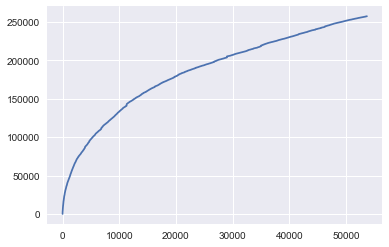

In [11]:
term_count_series = pd.Series(tfidf.term_count_over_iterations)
term_count_series.plot()

### Top words for Asian black bear

In [12]:
abb_idx = fauna[fauna['title']=='Asian black bear'].index[0]
print(tfidf.get_sorted_terms_for_document(abb_idx).head(20))

bears         1.340566
bear          0.684123
black         0.514237
asian         0.292425
to            0.140059
will          0.125510
and           0.124383
have          0.105714
asiatic       0.098804
ursus         0.097197
their         0.096326
they          0.095895
are           0.095319
thibetanus    0.090546
as            0.087520
than          0.086124
tiger         0.085674
hunting       0.085575
india         0.084920
cubs          0.083660
dtype: float64


### Top words for Sun bear

In [13]:
sb_idx = fauna[fauna['title']=='Sun bear'].index[0]
print(tfidf.get_sorted_terms_for_document(sb_idx).head(20))

sun           1.032571
bear          0.956376
bears         0.470372
bile          0.286178
malayanus     0.238481
helarctos     0.225075
honey         0.202648
malayan       0.184175
claws         0.176605
and           0.169571
kalimantan    0.157548
are           0.149519
mound         0.145788
their         0.141885
southeast     0.135953
they          0.134890
termites      0.129149
for           0.117258
sabah         0.115186
paws          0.112623
dtype: float64


### Computer the Euclidean distance between the Asian black bear and the Sun bear

In [14]:
asian_black_bear = tfidf[abb_idx].toarray()
sun_bear = tfidf[sb_idx].toarray()
np.linalg.norm(asian_black_bear - sun_bear)

1.898834915880105

### Top words for Flatfish

In [22]:
ff_idx = fauna[fauna['title'] == 'Flatfish'].index[0]
print(tfidf.get_sorted_terms_for_document(ff_idx).head(20))

flatfishes        0.612517
flatfish          0.460255
side              0.248945
families          0.223232
soleidae          0.182676
pleuronectidae    0.180269
fish              0.173355
bottom            0.168934
head              0.148232
hybrids           0.138811
right             0.138650
eyes              0.135971
turbots           0.131364
amphistium        0.131364
dextral           0.128280
achiridae         0.128280
cynoglossidae     0.128280
sinistral         0.125760
platichthys       0.123630
some              0.122857
dtype: float64


### Top words for Hagfish

In [23]:
hf_idx = fauna[fauna['title'] == 'Hagfish'].index[0]
print(tfidf.get_sorted_terms_for_document(hf_idx).head(20))

hagfish          2.021367
slime            0.521616
lampreys         0.281539
myxine           0.275481
vertebrates      0.240058
craniata         0.197047
duct             0.196514
gill             0.164350
to               0.163254
knot             0.151613
as               0.150045
cyclostomata     0.141909
gnathostomata    0.137740
mucus            0.117616
skin             0.112077
their            0.110834
opening          0.106651
have             0.105548
and              0.098852
mesonephric      0.098523
dtype: float64


In [26]:
# Euclidian distance between the Flatfish and the Hagfish
flatfish = tfidf[ff_idx].toarray()
hagfish = tfidf[hf_idx].toarray()
np.linalg.norm(hagfish - flatfish)

2.7082676133675863

In [27]:
# Euclidian distance between the Sub bear and the Hagfish
np.linalg.norm(sun_bear - asian_black_bear)

1.8988349158801048